# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [133]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import accuracy_score
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [42]:
def gini(x: np.ndarray) -> float:
    """
    Считает коэффициент Джини для массива меток x.
    """
    classes = np.unique(x)
    n = x.shape[0]
    prob = [len(np.where(x == c)[0]) / n for c in classes]
    prob = np.array([(1 - p) * p for p in prob])
    return np.sum(prob)
    
def entropy(x: np.ndarray) -> float:
    """
    Считает энтропию для массива меток x.
    """
    classes = np.unique(x)
    n = x.shape[0]
    prob = [len(np.where(x == c)[0]) / n for c in classes]
    prob = np.array([p * np.log2(p) for p in prob])
    return -np.sum(prob)

def gain(left_y: np.ndarray, right_y: np.ndarray, criterion: Callable) -> float:
    """
    Считает информативность разбиения массива меток.

    Parameters
    ----------
    left_y : np.ndarray
        Левая часть разбиения.
    right_y : np.ndarray
        Правая часть разбиения.
    criterion : Callable
        Критерий разбиения.
    """
    l_rate = left_y.shape[0] / (left_y.shape[0] + right_y.shape[0])
    r_rate = 1 - l_rate
    y = np.concatenate((left_y, right_y), axis=None)
    IG = criterion(y) - l_rate * criterion(left_y) - r_rate  * criterion(right_y)
    return IG

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

In [43]:
class DecisionTreeLeaf:
    """

    Attributes
    ----------
    y : int
        Метка класса, которая встречается чаще всего среди элементов листа дерева
    leaf_prediction : dict
        Словарь, отображающий метки в вероятность того, что объект, попавший в данный лист, принадлжит классу, соответствующиему метке 
    """
    def __init__(self, y):
        self.y = None
        self.leaf_prediction = {}
        classes = np.unique(y)
        for key in classes:          
            self.leaf_prediction[key] = len(np.where(y < key)) / len(y)
        self.y = max(self.leaf_prediction, key=self.leaf_prediction.get)


class DecisionTreeNode:
    """

    Attributes
    ----------
    split_dim : int
        Измерение, по которому разбиваем выборку.
    split_value : float
        Значение, по которому разбираем выборку.
    left : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] < split_value.
    right : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] >= split_value. 
    """
    def __init__(self, split_dim: int, split_value: float, 
                 left: Union['DecisionTreeNode', DecisionTreeLeaf], 
                 right: Union['DecisionTreeNode', DecisionTreeLeaf]):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right


### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [44]:
class DecisionTreeClassifier:
    """
    Attributes
    ----------
    root : Union[DecisionTreeNode, DecisionTreeLeaf]
        Корень дерева.

    (можете добавлять в класс другие аттрибуты).

    """
    def __init__(self, criterion : str = "gini", 
                 max_depth : Optional[int] = None, 
                 min_samples_leaf: int = 1):
        """
        Parameters
        ----------
        criterion : str
            Задает критерий, который будет использоваться при построении дерева.
            Возможные значения: "gini", "entropy".
        max_depth : Optional[int]
            Ограничение глубины дерева. Если None - глубина не ограничена.
        min_samples_leaf : int
            Минимальное количество элементов в каждом листе дерева.

        """
        self.root = None
        self.criterion = gini if criterion == 'gini' else entropy
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
        
    def split(self, X: np.ndarray, y: np.ndarray):
        n, m = X.shape
        best_gain, best_dim, best_value = -1, -1, -1
        features = np.array([np.unique([X[j][i] for j in range(n)]) for i in range(m)]) 
        for dim, feature in enumerate(features):
            for val in feature:
                mask_left = X[:, dim] < val
                mask_right = X[:, dim] >= val
                left = y[mask_left]
                right = y[mask_right]
                if len(left) < self.min_samples_leaf or len(right) < self.min_samples_leaf:
                    continue
                current_gain = gain(left, right, self.criterion)
                if current_gain > best_gain:
                    best_dim, best_value, best_gain = dim, val, current_gain
        return best_dim, best_value


    def build(self, X: np.ndarray, y: np.ndarray, depth: int):
        if depth > self.max_depth:
            return DecisionTreeLeaf(y)
        depth += 1   
        best_dim, best_value = self.split(X, y)
        if best_dim == -1:
          return DecisionTreeLeaf(y)
        mask_left = X[:, best_dim] < best_value
        mask_right = X[:, best_dim] >= best_value
        left = self.build(X[mask_left], y[mask_left], depth)
        right = self.build(X[mask_right], y[mask_right], depth)
        return DecisionTreeNode(best_dim, best_value, left, right)


    def recursion(self, x, node):
        if isinstance(node, DecisionTreeLeaf):
            return node.leaf_prediction
        elif x[node.split_dim] < node.split_value:
            return self.recursion(x, node.left)
        else:      
          return self.recursion(x, node.right)


    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Строит дерево решений по обучающей выборке.

        Parameters
        ----------
        X : np.ndarray
            Обучающая выборка.
        y : np.ndarray
            Вектор меток классов.
        """
        self.root = self.build(X, y, depth=0)


    def predict_proba(self, X: np.ndarray) ->  List[Dict[Any, float]]:
        """
        Предсказывает вероятность классов для элементов из X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.
        
        Return
        ------
        List[Dict[Any, float]]
            Для каждого элемента из X возвращает словарь 
            {метка класса -> вероятность класса}.
        """
        
        y_pred = [self.recursion(x, self.root) for x in X]
        return y_pred
    
    def predict(self, X : np.ndarray) -> list:
        """
        Предсказывает классы для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.
        
        Return
        ------
        list
            Вектор предсказанных меток для элементов X.
        """
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]



Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [45]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [46]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

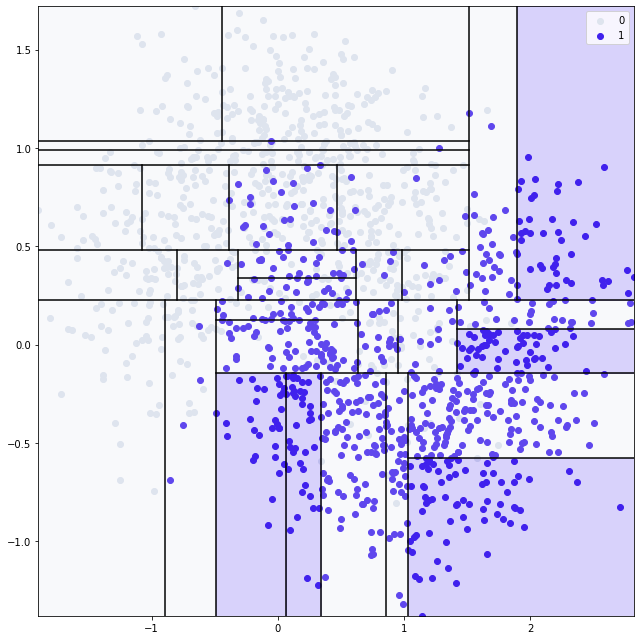

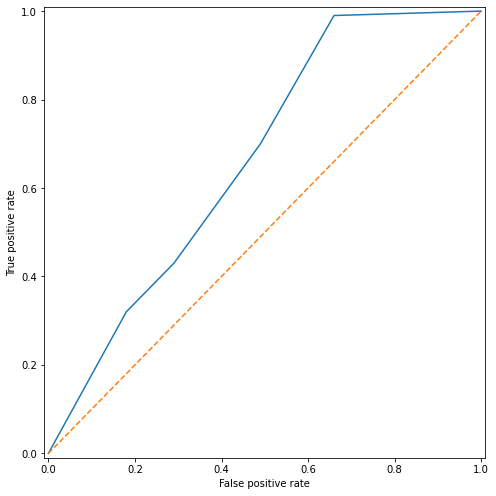

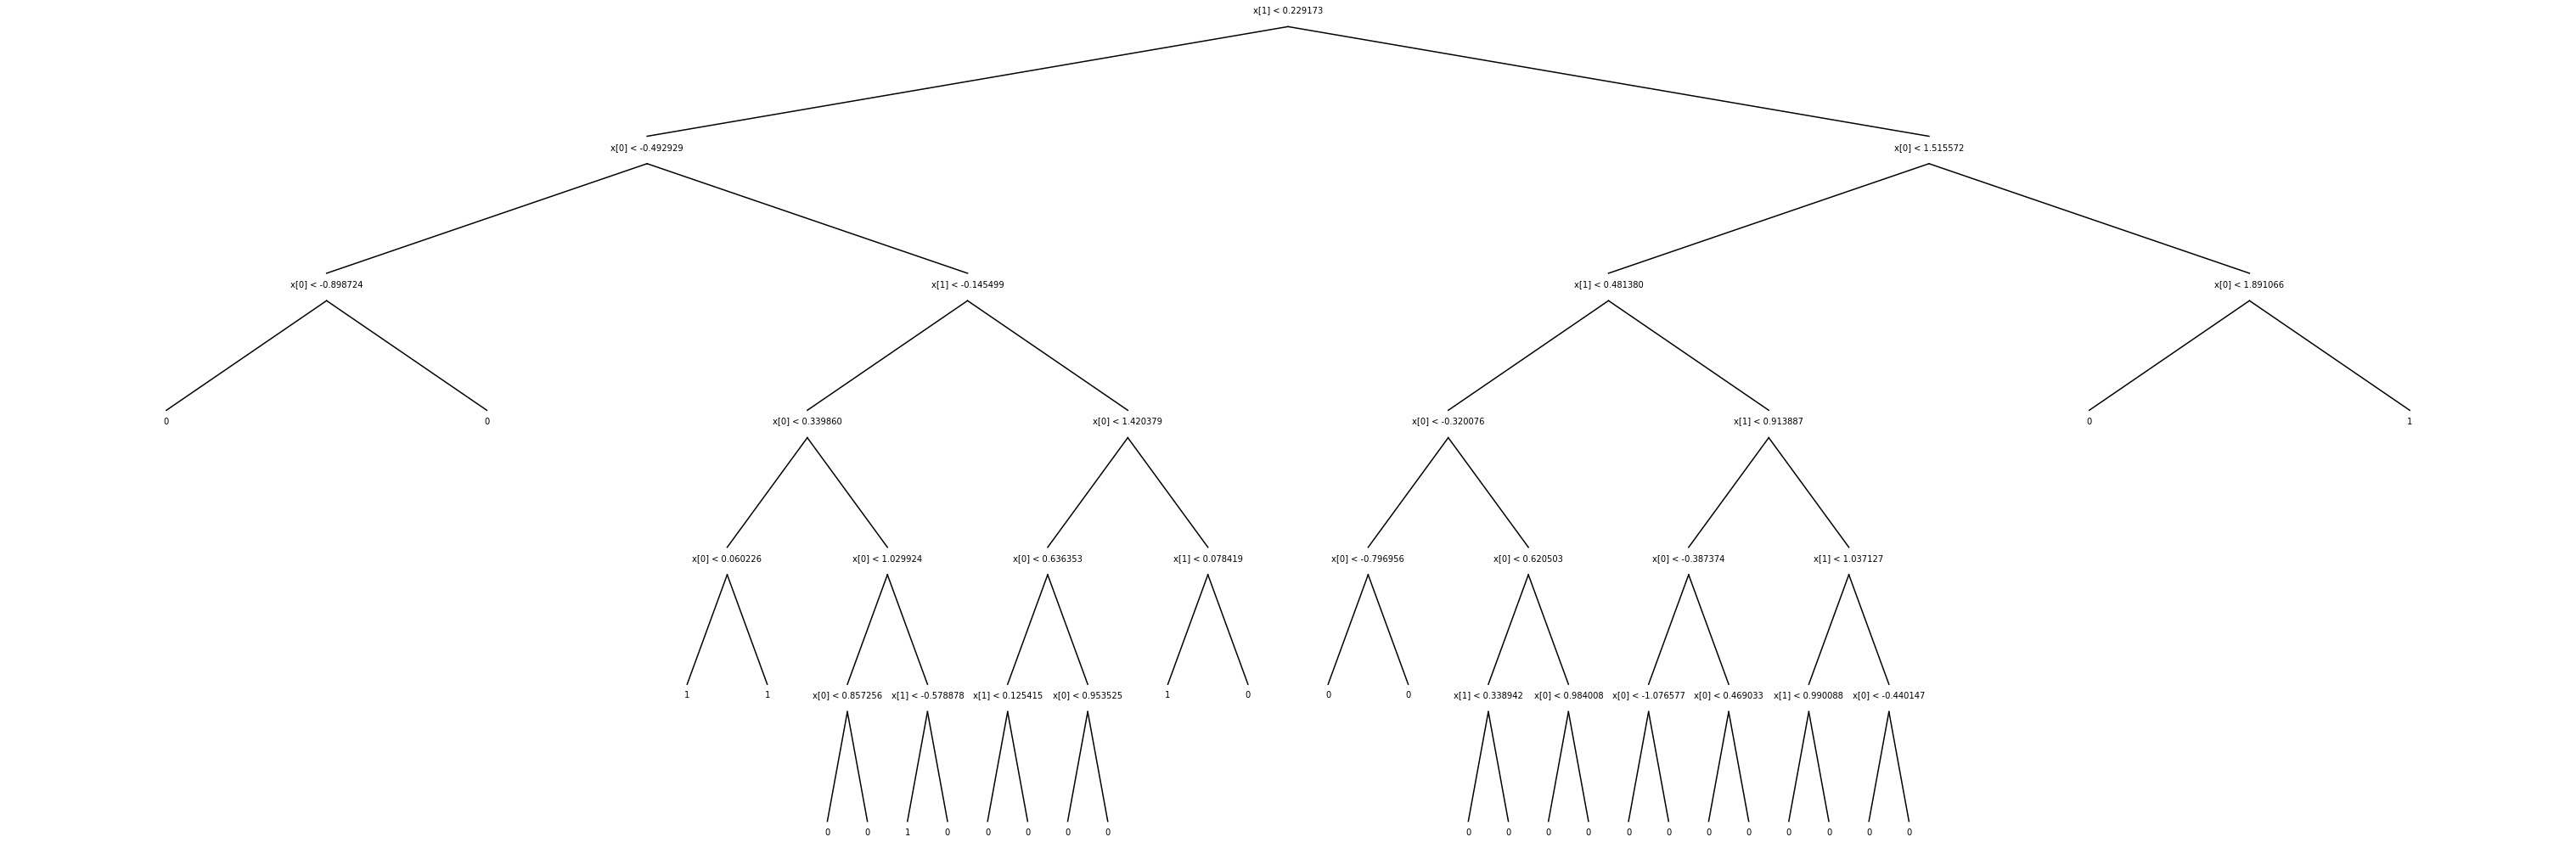

In [47]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

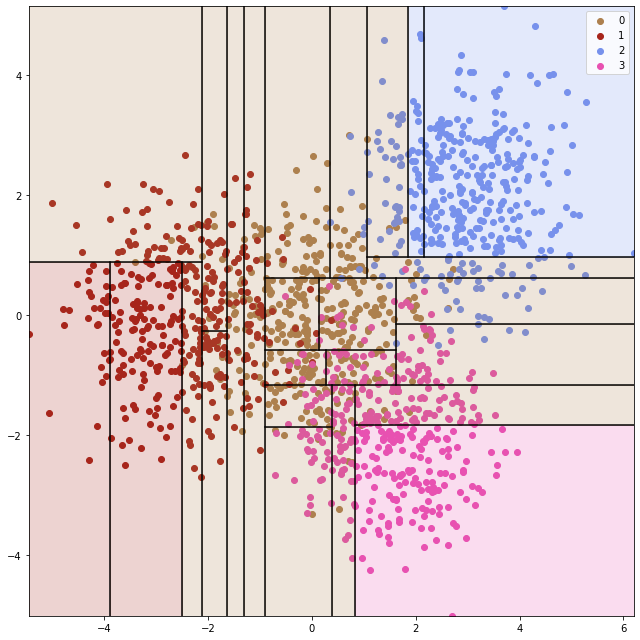

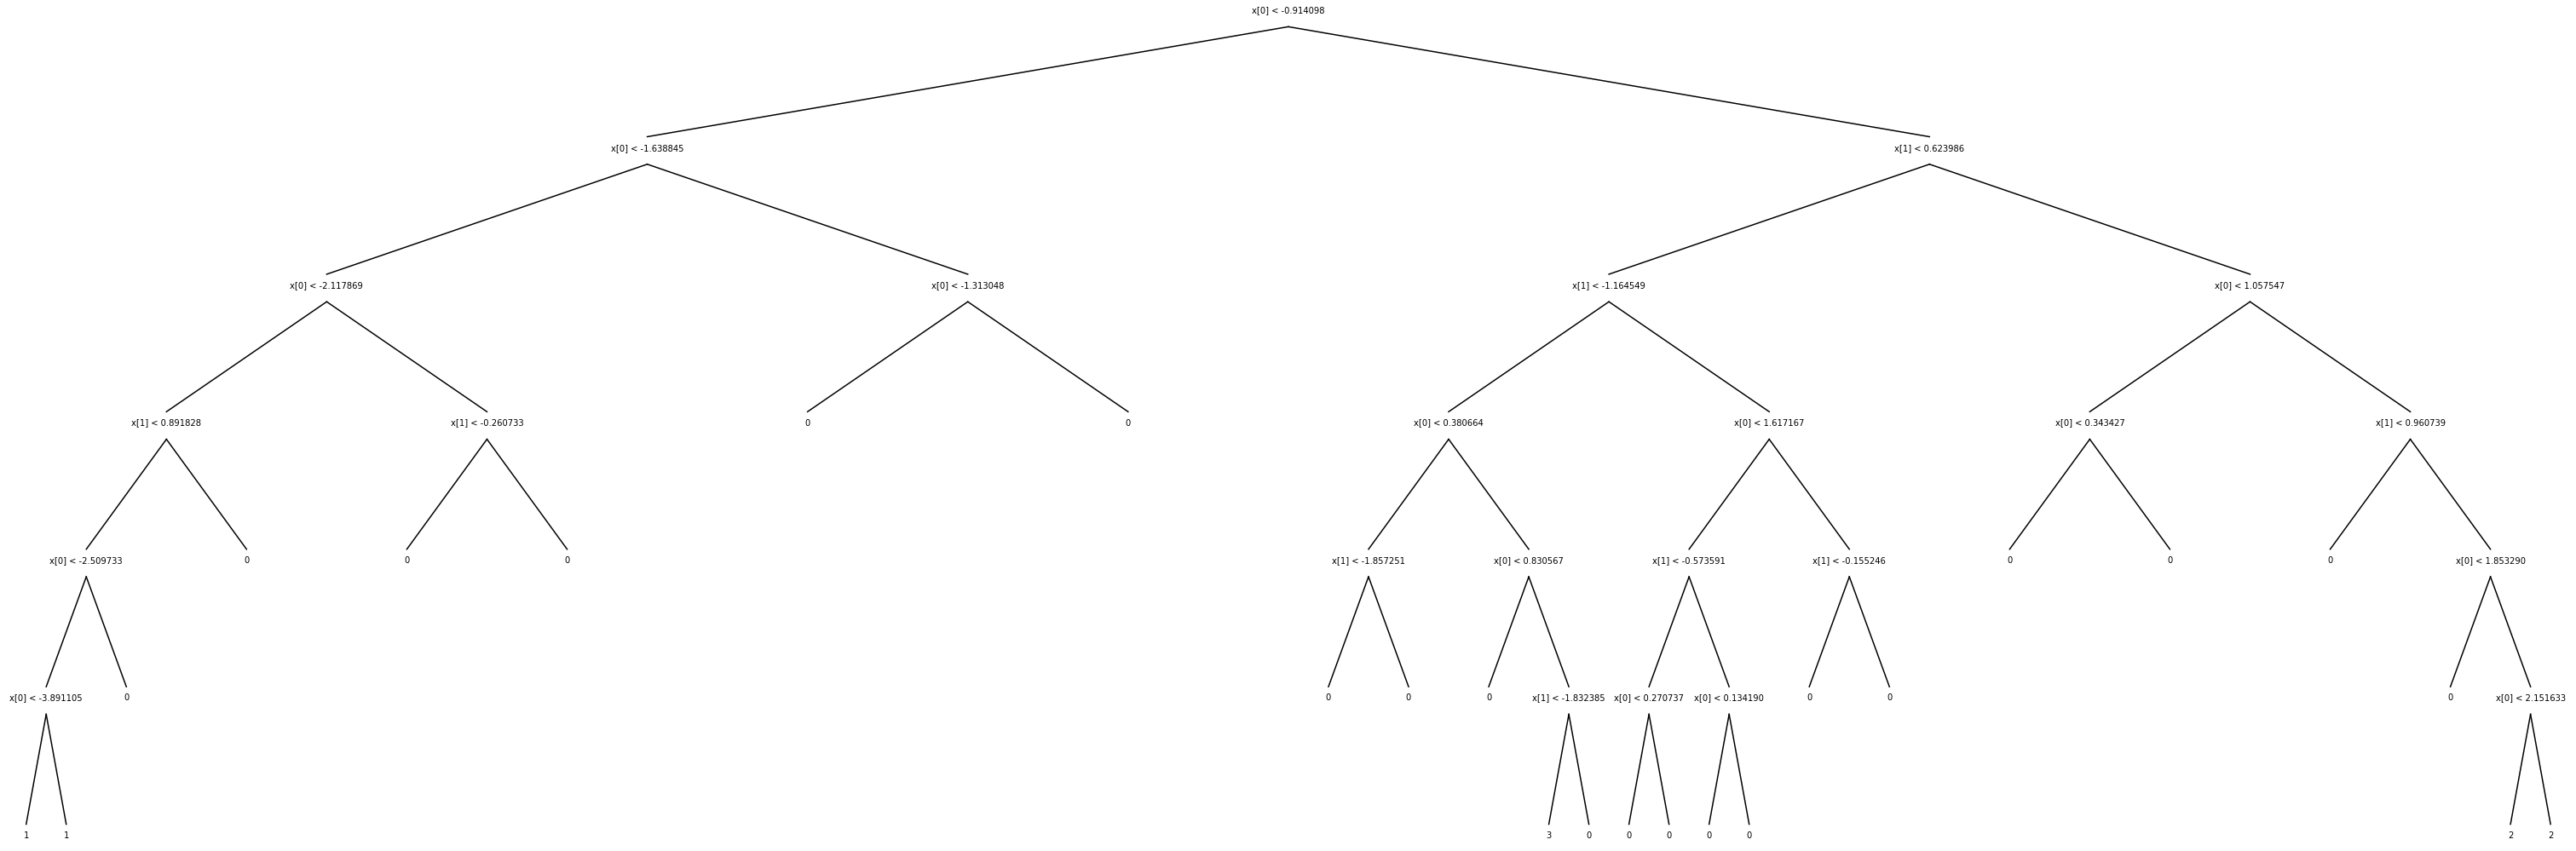

In [48]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (3 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 1 балл - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 3 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [134]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
SEED = 9799
random.seed(SEED)
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=1)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

In [147]:
X, y = read_dataset("/content/drive/MyDrive/Colab Notebooks/train.csv")
ratio = int(X.shape[0] * 0.8)
X_train, y_train = X[:ratio, :], y[:ratio]
X_val, y_val = X[ratio:, :], y[ratio:]
dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10, criterion='entropy')
dtc.fit(X_train, y_train)
test_predictions = dtc.predict(X_train)
print(f'Accuracy on test dataset: {accuracy_score(y_train, test_predictions)}')
val_predictions = dtc.predict(X_val)
print(f'Accuracy on validation dataset: {accuracy_score(y_val, val_predictions)}')

Accuracy on test dataset: 0.8872651356993737
Accuracy on validation dataset: 0.8666666666666667


### Задание 5 (1 балл)
От игроков начали поступать жалобы на то, что класс их персонажа внезапно сменился. В таких случаях модераторы смотрят на данные персонажа и пытаются восстановить его класс сами. Для того, чтобы им было проще это сделать, нужно научиться для каждого персонажа объяснять, почему дерево решений присвоило персонажу именно такой класс.

Реализуйте функцию `predict_explain(dtc, X)`. Для каждого элемента элемента набора данных `X` она должна вернуть пару из предсказанного класса и человекочетаемой строковой записи условий, благодаря которым был предсказан класс. 

In [148]:
def predict_explain(dtc: DecisionTreeClassifier, X: np.ndarray):
    headers = ['monster kills per death', 'death in pvp percentage',	'player kills per death',	'accuracy']
    interpretation = [[] for i in range(len(X))]
    for i, x in enumerate(X):
        class_predicted = dtc.predict([x])[0]
        node = dtc.root
        while isinstance(node, DecisionTreeNode):
            dim, value = node.split_dim, node.split_value
            left, right = node.left, node.right
            if x[dim] < value:
                ans = 'smaller'
                node = left
            else:
                ans = 'greater'
                node = right
            string_to_print = f'Question: {headers[dim]} greater or smaller than {round(x[dim], 1)}? \n             Answer: {ans}.'
            interpretation[i] = [class_predicted] + [string_to_print]
    return interpretation

In [131]:
X, y = read_dataset("/content/drive/MyDrive/Colab Notebooks/train.csv")
for pred_y, expl in predict_explain(dtc, X[:20]):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()

Class: cleric
Explanation: Question: monster kills per death greater or smaller than 0.7? 
             Answer: greater.

Class: rogue
Explanation: Question: monster kills per death greater or smaller than 2.9? 
             Answer: greater.

Class: rogue
Explanation: Question: monster kills per death greater or smaller than 3.2? 
             Answer: greater.

Class: warrior
Explanation: Question: death in pvp percentage greater or smaller than 0.7? 
             Answer: greater.

Class: rogue
Explanation: Question: player kills per death greater or smaller than 5.8? 
             Answer: greater.

Class: cleric
Explanation: Question: monster kills per death greater or smaller than 0.6? 
             Answer: greater.

Class: cleric
Explanation: Question: monster kills per death greater or smaller than 0.2? 
             Answer: smaller.

Class: rogue
Explanation: Question: monster kills per death greater or smaller than 0.7? 
             Answer: smaller.

Class: cleric
Explanation: Q